In [1]:
import pandas as pd
from Bio.SeqUtils import IsoelectricPoint
import re
from collections import Counter
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind
import matplotlib.colors as mcolors
from matplotlib_venn import venn3
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import itertools

plt.rcParams["svg.fonttype"] = "none"

**MICROSCOPY DEFINED PROTEINS**

**Import the mouse proteome from Uniprot**

In [2]:
uniprot_data_all = pd.read_csv('data/uniprot_data/uniprotkb_taxonomy_id_10090_2025_03_25.tsv', sep='\t')
uniprot_data_all

/tmp/ipykernel_2484144/2471962900.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  uniprot_data_all = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/data/uniprot_data/uniprotkb_taxonomy_id_10090_2025_03_25.tsv', sep='\t')


,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Compositional bias,Mass,Sequence,...,Redox potential,Region,Ensembl,Coiled coil,Domain [CC],Domain [FT],Motif,Repeat,Zinc finger,Gene Ontology (cellular component)
0,A0A075F5C6,unreviewed,A0A075F5C6_MOUSE,Heat shock factor 1 (Heat shock transcription ...,Hsf1,Mus musculus (Mouse),531,"COMPBIAS 343..355; /note=""Polar residues""; /ev...",57879,MDLAVGPGAAGPSNVPAFLTKLWTLVSDPDTDALICWSPSGNSFHV...,...,NaN,"REGION 272..327; /note=""Disordered""; /evidence...",ENSMUST00000228371.2;,NaN,NaN,"DOMAIN 57..81; /note=""HSF-type DNA-binding""; /...",NaN,NaN,NaN,centrosome [GO:0005813]; cytosol [GO:0005829];...
1,A0A087WPF7,reviewed,AUTS2_MOUSE,Autism susceptibility gene 2 protein homolog,Auts2 Kiaa0442,Mus musculus (Mouse),1261,"COMPBIAS 8..17; /note=""Basic residues""; /evide...",138920,MDGPTRGHGLRKKRRSRSQRDRERRSRAGLGTGAAGGIGAGRTRAP...,...,NaN,"REGION 1..88; /note=""Disordered""; /evidence=""E...",ENSMUST00000161226.11 [A0A087WPF7-1];ENSMUST00...,NaN,DOMAIN: The Pro-rich region is important for t...,NaN,NaN,NaN,NaN,cytoplasm [GO:0005737]; cytoskeleton [GO:00058...
2,A0A087WPT2,unreviewed,A0A087WPT2_MOUSE,Prostaglandin-endoperoxide synthase 2,Ptgs2,Mus musculus (Mouse),62,NaN,7199,MSTGFDQYKCDCTRTGFYGENCTTPEFLTRIKLLLKPTPNTVHYIL...,...,NaN,NaN,ENSMUST00000190784.2;,NaN,NaN,"DOMAIN 1..23; /note=""EGF-like""; /evidence=""ECO...",NaN,NaN,NaN,NaN
3,A0A087WRK1,unreviewed,A0A087WRK1_MOUSE,"Predicted gene, 20814 (Predicted gene, 20855) ...",Gm20905 Gm20814 Gm20835 Gm20850 Gm20855 Gm2086...,Mus musculus (Mouse),222,NaN,25620,MRRMALKKLKVIPKEGYLLLLDFDDEDDDIKVSEEALSEVKSPAFD...,...,NaN,"REGION 39..64; /note=""Disordered""; /evidence=""...",ENSMUST00000185240.2;ENSMUST00000185245.2;ENSM...,NaN,NaN,"DOMAIN 112..220; /note=""XLR/SYCP3/FAM9""; /evid...",NaN,NaN,NaN,cytoplasm [GO:0005737]; nucleus [GO:0005634]
4,A0A087WRT4,unreviewed,A0A087WRT4_MOUSE,FAT atypical cadherin 1,Fat1,Mus musculus (Mouse),4602,"COMPBIAS 4258..4267; /note=""Polar residues""; /...",507531,MGRHLTLLLLLLLFLQQFGDSDGSQRLEPTPPIQFTHFQYNVTVHE...,...,NaN,"REGION 4256..4292; /note=""Disordered""; /eviden...",ENSMUST00000189017.8;,NaN,NaN,"DOMAIN 36..150; /note=""Cadherin""; /evidence=""E...",NaN,NaN,NaN,apical plasma membrane [GO:0016324]; cell junc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87487,Z4YN82,unreviewed,Z4YN82_MOUSE,Syntaphilin,Snph,Mus musculus (Mouse),87,NaN,9364,MAMSLQGSRRASAGSRRRTSPPVSVRDAYGTSSLSSSSNSGSCKGS...,...,NaN,"REGION 1..74; /note=""Disordered""; /evidence=""E...",ENSMUST00000137936.2;,NaN,NaN,NaN,NaN,NaN,NaN,membrane [GO:0016020]
87488,Z4YN86,unreviewed,Z4YN86_MOUSE,Translocase of inner mitochondrial membrane 22,Timm22,Mus musculus (Mouse),116,NaN,12689,MAATAPKAGGSAPEAAGSAEAPLQYSLLLQYLVGDKRQPRLLEPGS...,...,NaN,NaN,ENSMUST00000152183.2;,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87489,Z4YN92,unreviewed,Z4YN92_MOUSE,A kinase anchor protein 17B,Akap17b,Mus musculus (Mouse),406,"COMPBIAS 24..52; /note=""Basic and acidic resid...",47765,MFDTTKHFSEGAIQRRNQERLKLQELEEERKKEKKREEEVAERKRK...,...,NaN,"REGION 24..90; /note=""Disordered""; /evidence=""...",ENSMUST00000133980.2;,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87490,Z4YN97,unreviewed,Z4YN97_MOUSE,Adenylate kinase 1,Ak1,Mus musculus (Mouse),89,NaN,9541,MEEKLKKAKIIFVVGGPGSGKGTQCEKIVQKYGYTHLSTGDLLRAE...,...,NaN,NaN,ENSMUST00000156578.8;,NaN,NaN,NaN,NaN,NaN,NaN,cytoplasm [GO:0005737]


**Select the enriched proteins in each nucleolar compartments based on p-value cutoff**

In [3]:
microscopy_derived_genes = pd.read_csv("data/microscopy_derived_proteome/Protein categorization_Mus musculus_Trupej_20241206.xlsx - Sheet1.tsv", sep="\t")
microscopy_derived_genes

,Gene.names,Localization
0,Polr1f/Twistnb,FC
1,Polr1a/Rpa1,FC
2,Cd3eap,FC
3,RPAC2/Polr1d,FC
4,RPAC1/Polr1c,FC
...,...,...
139,Tma16,ITS2
140,NHP2/Nola2,ITS2
141,Nop53/Gltscr2/Pict1,ITS2
142,Gtpbp4/Crfg/Nog1,ITS2


**Map gene names to protein IDs**

In [4]:
def uniprot_mapping(data1, data2):

    data1['gene_list'] = (
        data1['Gene Names']
        .fillna('')
        .str.lower()
        .str.split()
        .apply(lambda genes: [g.replace(' ', '') for g in genes])
    )

    data2['gene_list'] = (
        data2['Gene.names']
        .fillna('')
        .str.lower()
        .str.split('/')
        .apply(lambda genes: [g.replace(' ', '') for g in genes])
    )

    def best_matches(g2):

        print(f"g2: {g2}")

        overlap = data1['gene_list'].apply(lambda g1: len(set(g1) & set(g2)))
        
        max_count = overlap.max()
        print(f"max_count: {max_count}")
        if max_count == 0:
            return []
        
        candidates = data1.loc[overlap == max_count]
        
        if len(candidates) > 1:
            reviewed = candidates[candidates['Reviewed'] == 'reviewed']
            if len(reviewed) >= 1:
                return reviewed['Entry'].tolist()
            
        return candidates['Entry'].tolist()

    data2['matched_entries'] = data2['gene_list'].apply(best_matches)


    def collect_matched_lists(entries):

        return [
            data1.loc[data1['Entry'] == e, 'gene_list'].iloc[0]
            for e in entries
        ]

    data2['matched_gene_lists'] = data2['matched_entries'].apply(collect_matched_lists)

    return data2

mapped_microscopy_derived_genes = uniprot_mapping(uniprot_data_all, microscopy_derived_genes)
mapped_microscopy_derived_genes

g2: ['polr1f', 'twistnb']
max_count: 2
g2: ['polr1a', 'rpa1']
max_count: 2
g2: ['cd3eap']
max_count: 1
g2: ['rpac2', 'polr1d']
max_count: 1
g2: ['rpac1', 'polr1c']
max_count: 1
g2: ['rpa12', 'polr1h', 'znrd1']
max_count: 3
g2: ['rpa2', 'polr1b']
max_count: 2
g2: ['rpa49', 'paf53', 'polr1e']
max_count: 2
g2: ['taf1a']
max_count: 1
g2: ['ubtf']
max_count: 1
g2: ['rrn3']
max_count: 1
g2: ['tif1a', 'trim24']
max_count: 2
g2: ['tcof1']
max_count: 1
g2: ['taf1c']
max_count: 1
g2: ['top1']
max_count: 1
g2: ['dkc1']
max_count: 1
g2: ['fbl']
max_count: 1
g2: ['gar1']
max_count: 1
g2: ['knop1', 'tsg118']
max_count: 2
g2: ['lyar']
max_count: 1
g2: ['nhp2', 'nola2']
max_count: 2
g2: ['nolc1', 'kiaa0035']
max_count: 2
g2: ['nop10', 'nola3']
max_count: 2
g2: ['nop56', 'nol5a']
max_count: 2
g2: ['nop58', 'nol5']
max_count: 2
g2: ['snu13', 'nhp2l1,ssfa1']
max_count: 1
g2: ['rrp9', 'rnu3ip2,u3-55k']
max_count: 1
g2: ['dhx15', 'ddx15,deah9']
max_count: 1
g2: ['adarb2', 'adar3,red2']
max_count: 1
g2: ['b

,Gene.names,Localization,gene_list,matched_entries,matched_gene_lists
0,Polr1f/Twistnb,FC,"[polr1f, twistnb]",[Q78WZ7],"[[polr1f, twistnb]]"
1,Polr1a/Rpa1,FC,"[polr1a, rpa1]",[O35134],"[[polr1a, rpa1, rpo1-4]]"
2,Cd3eap,FC,[cd3eap],[Q76KJ5],"[[polr1g, ase1, cd3eap, paf49]]"
3,RPAC2/Polr1d,FC,"[rpac2, polr1d]",[P97304],"[[polr1d, rpo1-3]]"
4,RPAC1/Polr1c,FC,"[rpac1, polr1c]",[P52432],"[[polr1c, rpo1-1]]"
...,...,...,...,...,...
139,Tma16,ITS2,[tma16],[Q9CR02],[[tma16]]
140,NHP2/Nola2,ITS2,"[nhp2, nola2]",[Q9CRB2],"[[nhp2, nola2]]"
141,Nop53/Gltscr2/Pict1,ITS2,"[nop53, gltscr2, pict1]",[Q8BK35],"[[nop53, gltscr2, pict1]]"
142,Gtpbp4/Crfg/Nog1,ITS2,"[gtpbp4, crfg, nog1]",[Q99ME9],"[[gtpbp4, crfg, nog1]]"


**Flatten to sets**

In [5]:
from itertools import chain

flat = mapped_microscopy_derived_genes.explode('matched_entries')

sets_by_loc = (
    flat.groupby('Localization')['matched_entries']
        .agg(set)          # turns the series of entries into a set
        .to_dict()         # { 'FC': {...}, 'ITS2': {...}, ... }
)

S47_genes   = sets_by_loc.get('FC', set())
ITS2_genes = sets_by_loc.get('ITS2', set())
S45_genes  = sets_by_loc.get('DFC', set())   # replace 'NUC' with your actual third category

S47_genes   = {gene for gene in S47_genes if isinstance(gene, str)}
ITS2_genes = {gene for gene in ITS2_genes if isinstance(gene, str)}
S45_genes  = {gene for gene in S45_genes if isinstance(gene, str)}

print("FC entries:",   len(S47_genes))
print("ITS2 entries:", len(ITS2_genes))
print("DFC entries:",  len(S45_genes))

FC entries: 15
ITS2 entries: 28
DFC entries: 13


**Venn diagram of the compartments**

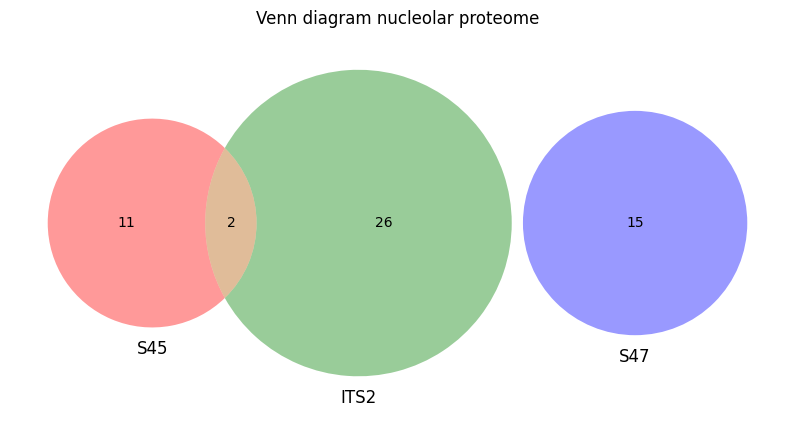

In [6]:
def venn3_plotting(sets, labels, name=None):

    plt.figure(figsize=(10, 7))
    venn3(sets, labels)
    plt.title(name)
    plt.show()

venn3_plotting([S45_genes, ITS2_genes, S47_genes], ['S45', 'ITS2', 'S47'], name="Venn diagram nucleolar proteome")


**Parsing composition and disorder from UniProt**

In [7]:
def extract_domain_notes(domain_str):
    if pd.isna(domain_str):
        return None

    notes = re.findall(r'/note="(.*?)"', domain_str)
    return notes if notes else None

def parse_disordered_regions(region_str):
    """Extract start-end ranges of disordered regions from the Region string."""
    if not isinstance(region_str, str):
        return []
    matches = re.findall(r'REGION (\d+)\.\.(\d+); /note="Disordered"', region_str)
    return [(int(start), int(end)) for start, end in matches]

def calculate_aa_composition(sequence):
    """Calculate amino acid composition as a percentage."""
    total = len(sequence)
    counts = Counter(sequence)
    return {aa: counts[aa] / total for aa in 'ACDEFGHIKLMNPQRSTVWY'}

def analyze_disorder(row):
    regions = parse_disordered_regions(row['Region'])
    full_seq = row['Sequence']
    total_len = len(full_seq)

    aa_compositions = []
    disordered_len = 0

    for start, end in regions:
        region_seq = full_seq[start-1:end]
        disordered_len += len(region_seq)
        aa_compositions.append(calculate_aa_composition(region_seq))

    if aa_compositions:
        avg_composition = {
            aa: sum(comp.get(aa, 0) for comp in aa_compositions) / len(aa_compositions)
            for aa in 'ACDEFGHIKLMNPQRSTVWY'
        }
    else:
        avg_composition = {aa: 0 for aa in 'ACDEFGHIKLMNPQRSTVWY'}

    disordered_indices = set()
    for start, end in regions:
        disordered_indices.update(range(start-1, end))
    ordered_indices = [i for i in range(total_len) if i not in disordered_indices]
    ordered_seq = ''.join(full_seq[i] for i in ordered_indices)
    if ordered_seq:
        non_disordered_composition = calculate_aa_composition(ordered_seq)
    else:
        non_disordered_composition = {aa: 0 for aa in 'ACDEFGHIKLMNPQRSTVWY'}

    return pd.Series({
        'Disorder_percent': disordered_len / total_len,
        'Num_disordered_regions': len(regions),
        'Disordered_AA_avg': ','.join(f'{aa}:{avg_composition[aa]:.2f}' for aa in 'ACDEFGHIKLMNPQRSTVWY'),
        'NonDisordered_AA_avg': ','.join(f'{aa}:{non_disordered_composition[aa]:.2f}' for aa in 'ACDEFGHIKLMNPQRSTVWY')
    })

uniprot_data_all["Parsed_Domains"] = uniprot_data_all["Domain [FT]"].apply(extract_domain_notes)
uniprot_data_all[['Disorder_percent', 'Num_disordered_regions', 'Disordered_AA_avg', 'NonDisordered_AA_avg']] = uniprot_data_all.apply(analyze_disorder, axis=1)

uniprot_data_all


,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Compositional bias,Mass,Sequence,...,Motif,Repeat,Zinc finger,Gene Ontology (cellular component),gene_list,Parsed_Domains,Disorder_percent,Num_disordered_regions,Disordered_AA_avg,NonDisordered_AA_avg
0,A0A075F5C6,unreviewed,A0A075F5C6_MOUSE,Heat shock factor 1 (Heat shock transcription ...,Hsf1,Mus musculus (Mouse),531,"COMPBIAS 343..355; /note=""Polar residues""; /ev...",57879,MDLAVGPGAAGPSNVPAFLTKLWTLVSDPDTDALICWSPSGNSFHV...,...,NaN,NaN,NaN,centrosome [GO:0005813]; cytosol [GO:0005829];...,[hsf1],[HSF-type DNA-binding],0.209040,3,"A:0.11,C:0.00,D:0.08,E:0.04,F:0.01,G:0.05,H:0....","A:0.06,C:0.01,D:0.06,E:0.06,F:0.04,G:0.05,H:0...."
1,A0A087WPF7,reviewed,AUTS2_MOUSE,Autism susceptibility gene 2 protein homolog,Auts2 Kiaa0442,Mus musculus (Mouse),1261,"COMPBIAS 8..17; /note=""Basic residues""; /evide...",138920,MDGPTRGHGLRKKRRSRSQRDRERRSRAGLGTGAAGGIGAGRTRAP...,...,NaN,NaN,NaN,cytoplasm [GO:0005737]; cytoskeleton [GO:00058...,"[auts2, kiaa0442]",None,0.665345,7,"A:0.07,C:0.00,D:0.05,E:0.06,F:0.02,G:0.06,H:0....","A:0.06,C:0.00,D:0.06,E:0.03,F:0.06,G:0.07,H:0...."
2,A0A087WPT2,unreviewed,A0A087WPT2_MOUSE,Prostaglandin-endoperoxide synthase 2,Ptgs2,Mus musculus (Mouse),62,NaN,7199,MSTGFDQYKCDCTRTGFYGENCTTPEFLTRIKLLLKPTPNTVHYIL...,...,NaN,NaN,NaN,NaN,[ptgs2],[EGF-like],0.000000,0,"A:0.00,C:0.00,D:0.00,E:0.00,F:0.00,G:0.00,H:0....","A:0.00,C:0.05,D:0.03,E:0.03,F:0.08,G:0.06,H:0...."
3,A0A087WRK1,unreviewed,A0A087WRK1_MOUSE,"Predicted gene, 20814 (Predicted gene, 20855) ...",Gm20905 Gm20814 Gm20835 Gm20850 Gm20855 Gm2086...,Mus musculus (Mouse),222,NaN,25620,MRRMALKKLKVIPKEGYLLLLDFDDEDDDIKVSEEALSEVKSPAFD...,...,NaN,NaN,NaN,cytoplasm [GO:0005737]; nucleus [GO:0005634],"[gm20905, gm20814, gm20835, gm20850, gm20855, ...",[XLR/SYCP3/FAM9],0.117117,1,"A:0.12,C:0.00,D:0.15,E:0.19,F:0.04,G:0.04,H:0....","A:0.03,C:0.02,D:0.08,E:0.11,F:0.03,G:0.04,H:0...."
4,A0A087WRT4,unreviewed,A0A087WRT4_MOUSE,FAT atypical cadherin 1,Fat1,Mus musculus (Mouse),4602,"COMPBIAS 4258..4267; /note=""Polar residues""; /...",507531,MGRHLTLLLLLLLFLQQFGDSDGSQRLEPTPPIQFTHFQYNVTVHE...,...,NaN,NaN,NaN,apical plasma membrane [GO:0016324]; cell junc...,[fat1],"[Cadherin, Cadherin, Cadherin, Cadherin, Cadhe...",0.050847,6,"A:0.04,C:0.01,D:0.08,E:0.10,F:0.03,G:0.05,H:0....","A:0.06,C:0.01,D:0.07,E:0.07,F:0.04,G:0.06,H:0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87487,Z4YN82,unreviewed,Z4YN82_MOUSE,Syntaphilin,Snph,Mus musculus (Mouse),87,NaN,9364,MAMSLQGSRRASAGSRRRTSPPVSVRDAYGTSSLSSSSNSGSCKGS...,...,NaN,NaN,NaN,membrane [GO:0016020],[snph],None,0.850575,1,"A:0.05,C:0.03,D:0.04,E:0.01,F:0.00,G:0.08,H:0....","A:0.00,C:0.08,D:0.00,E:0.08,F:0.00,G:0.00,H:0...."
87488,Z4YN86,unreviewed,Z4YN86_MOUSE,Translocase of inner mitochondrial membrane 22,Timm22,Mus musculus (Mouse),116,NaN,12689,MAATAPKAGGSAPEAAGSAEAPLQYSLLLQYLVGDKRQPRLLEPGS...,...,NaN,NaN,NaN,NaN,[timm22],None,0.000000,0,"A:0.00,C:0.00,D:0.00,E:0.00,F:0.00,G:0.00,H:0....","A:0.12,C:0.02,D:0.01,E:0.08,F:0.01,G:0.10,H:0...."
87489,Z4YN92,unreviewed,Z4YN92_MOUSE,A kinase anchor protein 17B,Akap17b,Mus musculus (Mouse),406,"COMPBIAS 24..52; /note=""Basic and acidic resid...",47765,MFDTTKHFSEGAIQRRNQERLKLQELEEERKKEKKREEEVAERKRK...,...,NaN,NaN,NaN,NaN,[akap17b],None,0.334975,3,"A:0.10,C:0.01,D:0.04,E:0.13,F:0.00,G:0.01,H:0....","A:0.04,C:0.02,D:0.05,E:0.10,F:0.02,G:0.05,H:0...."
87490,Z4YN97,unreviewed,Z4YN97_MOUSE,Adenylate kinase 1,Ak1,Mus musculus (Mouse),89,NaN,9541,MEEKLKKAKIIFVVGGPGSGKGTQCEKIVQKYGYTHLSTGDLLRAE...,...,NaN,NaN,NaN,cytoplasm [GO:0005737],[ak1],None,0.000000,0,"A:0.00,C:0.00,D:0.00,E:0.00,F:0.00,G:0.00,H:0....","A:0.06,C:0.01,D:0.06,E:0.08,F:0.01,G:0.12,H:0...."


**Clean up the dataframe and format**

In [8]:
rows = []

lists = [S45_genes, S47_genes, ITS2_genes]
names = ["S45", "S47", "ITS2"]

for i, l in enumerate(lists):
    for gene in l:
        if ";" in gene:
            gene_sep = gene.split(";")
            for g in gene_sep:
                if g not in uniprot_data_all["Entry"].values:
                    print(f"{g} not in uniprot data")
                    continue

                rows.append({
                    "Majority.protein.IDs": gene,
                    "Reviewed": uniprot_data_all[uniprot_data_all["Entry"] == g]["Reviewed"].values[0],
                    "Protein ID": g,
                    "Sequence": uniprot_data_all[uniprot_data_all["Entry"] == g]["Sequence"].values[0],
                    "Label": names[i],
                    "Parsed_Domains" : uniprot_data_all[uniprot_data_all["Entry"] == g]["Parsed_Domains"].values[0],
                    "Disorder_percent": uniprot_data_all[uniprot_data_all["Entry"] == g]["Disorder_percent"].values[0],
                    "Num_disordered_regions": uniprot_data_all[uniprot_data_all["Entry"] == g]["Num_disordered_regions"].values[0],
                })
        else:
            g = gene
            if g not in uniprot_data_all["Entry"].values:
                print(f"{g} not in uniprot data")
                continue
            seq = uniprot_data_all[uniprot_data_all["Entry"] == g]["Sequence"].values[0]
            reviewed = uniprot_data_all[uniprot_data_all["Entry"] == g]["Reviewed"].values[0]
            rows.append({
                "Majority.protein.IDs": gene,
                "Reviewed": uniprot_data_all[uniprot_data_all["Entry"] == g]["Reviewed"].values[0],
                "Protein ID": g,
                "Sequence": uniprot_data_all[uniprot_data_all["Entry"] == g]["Sequence"].values[0],
                "Label": names[i],
                "Parsed_Domains" : uniprot_data_all[uniprot_data_all["Entry"] == g]["Parsed_Domains"].values[0],
                "Disorder_percent": uniprot_data_all[uniprot_data_all["Entry"] == g]["Disorder_percent"].values[0],
                "Num_disordered_regions": uniprot_data_all[uniprot_data_all["Entry"] == g]["Num_disordered_regions"].values[0],
            })

cleaned_data = pd.DataFrame(rows)
cleaned_data

,Majority.protein.IDs,Reviewed,Protein ID,Sequence,Label,Parsed_Domains,Disorder_percent,Num_disordered_regions
0,Q9CQS2,reviewed,Q9CQS2,MFLQYYLNEQGDRVYTLKKFDPMGQQTCSAHPARFSPDDKYSRHRI...,S45,None,0.000000,0
1,Q08288,reviewed,Q08288,MVFFTCNACGESVKKIQVEKHVSNCRNCECLSCIDCGKDFWGDDYK...,S45,None,0.461340,1
2,Q9D6Z1,reviewed,Q9D6Z1,MVLLHVLFEHAVGYALLALKEVEEISLLLPQVEECVLNLGKFHNVV...,S45,[Nop],0.212069,1
3,Q6DFW4,reviewed,Q6DFW4,MLVLFETSVGYAIFKVLNEKKLQEVDSLWKEFETPEKANKIVKLKH...,S45,[Nop],0.175373,2
4,Q9CY66,reviewed,Q9CY66,MSFRGGGRGGFNRGGGGGGFNRGGGSNNHFRGGGGGGGGSFRGGGG...,S45,None,0.606061,2
5,Q9Z2Q2,reviewed,Q9Z2Q2,MVSKTQKADLGPQLPEKKKKKKKKKRVVANVSEPETQYSVLNSNDY...,S45,None,0.684100,3
6,Q91WM3,reviewed,Q91WM3,MSTAVATRKRAKPAPGPGAAPVAGKRRRKVDSAADRGKSKGGGKMN...,S45,None,0.157895,1
7,P35550,reviewed,P35550,MKPGFSPRGGGFGGRGGFGDRGGRGGGRGGRGGFGGGRGGFGGGGR...,S45,None,0.290520,1
8,Q9CRB2,reviewed,Q9CRB2,MTKVKAAPEESEAQAEGCSEERTYKELLVNLNPIAQPLASRRLTRK...,S45,None,0.000000,0
9,Q9ESX5,reviewed,Q9ESX5,MADAEVITFPKKHKKKKDRKPLQEDDVAEIQHAEEFLIKPESKVAQ...,S45,[PUA],0.170923,2


**Only select the review-ed or longest protein per Majority.protein.IDs**

In [9]:
cleaned_data["SeqLength"] = cleaned_data["Sequence"].apply(len)

final_rows = []

for protein_group, group_df in cleaned_data.groupby(["Majority.protein.IDs", "Label"]):
    reviewed_df = group_df[group_df["Reviewed"] == "reviewed"]

    if len(reviewed_df) == 1:
        final_rows.append(reviewed_df.iloc[0])

    elif len(reviewed_df) > 1:
        reviewed_df["SeqLength"] = reviewed_df["Sequence"].apply(len)
        longest = reviewed_df.sort_values("SeqLength", ascending=False).iloc[0]
        final_rows.append(longest)

    else:
        group_df["SeqLength"] = group_df["Sequence"].apply(len)
        longest = group_df.sort_values("SeqLength", ascending=False).iloc[0]
        final_rows.append(longest)

final_df = pd.DataFrame(final_rows).drop(columns=["SeqLength"]).reset_index(drop=True)
final_df["Length"] = final_df["Sequence"].apply(len)
sorted_df = final_df.sort_values("Length", ascending=False)
sorted_df["Label"].value_counts()
sorted_df

,Majority.protein.IDs,Reviewed,Protein ID,Sequence,Label,Parsed_Domains,Disorder_percent,Num_disordered_regions,Length
5,O35134,reviewed,O35134,MLASKHTPWRRLQGISFGMYSAEELKKLSVKSITNPRYVDYLGNPS...,S47,None,0.071054,1,1717
4,O08784,reviewed,O08784,MAEARKRRELLPLIYHHLLQAGYVRAAREVKEQSGQKSFLTQPVTL...,S47,[LisH],0.930303,2,1320
15,P70700,reviewed,P70700,MDVDGRWRNLPSGPSLKHLTDPSYGIPPEQQKAALQDLTRAHVDSF...,S47,None,0.022907,1,1135
21,Q64127,reviewed,Q64127,MEVAVEKAAAAAAPAGGPAAAAPSGENEAESRQGPDSESGGEASRL...,S47,[Bromo],0.305423,7,1051
45,Q9CZU3,reviewed,Q9CZU3,MADAFGDELFSVFEDDSTSAAGAKKDKEKEKWKGPPGSADKAGKRL...,ITS2,"[Helicase ATP-binding, Helicase C-terminal]",0.059615,1,1040
52,Q9DBR1,reviewed,Q9DBR1,MGVPAFFRWLSRKYPSIIVNCVEEKPKECNGVKIPVDASKPNPNDV...,ITS2,None,0.153523,2,951
12,P56960,reviewed,P56960,MAPPSPREHQSAPATSATKPDAEMVLPGFPDADSFVKFALGSVVAV...,ITS2,"[3'-5' exonuclease, HRDC]",0.178129,3,887
24,Q6PDZ2,reviewed,Q6PDZ2,MDFPGTLRPSLFKAGPLGMTDGPDLSFMCSWRDALTLPGSQPQNCK...,S47,None,0.186603,2,836
6,O35286,reviewed,O35286,MSKRHRLDLGEDYPSGKKRAGTDGKDRERDRDREDRSKDRDRERDR...,S45,"[Helicase ATP-binding, Helicase C-terminal]",0.139623,1,795
0,A2BE28,reviewed,A2BE28,MDRVWRAWDGQSFKENQPESPSARGIVVSWLSRAEWEQVTVYLFCD...,ITS2,None,0.304124,3,776


**Add all nuclear proteins from UniProt as control set excluding the ones in compartments**

In [10]:
nuclear_proteome_data = pd.read_csv('data/uniprot_data/uniprotkb_taxonomy_id_10090_AND_go_0005_2025_03_25.tsv', sep='\t')
print(nuclear_proteome_data.shape)
nuclear_proteome_data = uniprot_data_all[(uniprot_data_all["Entry"].isin(nuclear_proteome_data["Entry"])) & (uniprot_data_all["Reviewed"] == "reviewed")]
print(nuclear_proteome_data.shape)

nuclear_proteome_data = nuclear_proteome_data[~nuclear_proteome_data["Entry"].isin(sorted_df["Protein ID"])]
print(nuclear_proteome_data.shape)

data_all_prots = pd.concat([sorted_df, nuclear_proteome_data], ignore_index=True)
print(nuclear_proteome_data.shape)

data_all_prots["Label"].fillna("All Nuclear Proteins", inplace=True)
data_all_prots["Length"] = data_all_prots["Sequence"].apply(len)
print(data_all_prots.shape)
data_all_prots['Sequence'] = data_all_prots['Sequence'].astype(str)
data_all_prots["Label"].value_counts()

(15776, 21)
(6024, 27)
(5971, 27)
(5971, 27)
(6027, 30)


/tmp/ipykernel_2484144/817584790.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_all_prots["Label"].fillna("All Nuclear Proteins", inplace=True)


Label
All Nuclear Proteins    5971
ITS2                      28
S47                       15
S45                       13
Name: count, dtype: int64

**Calculate the difference in means between control and each compartment and plotting with radarplot with bootstrapping for CI of the diff in means**

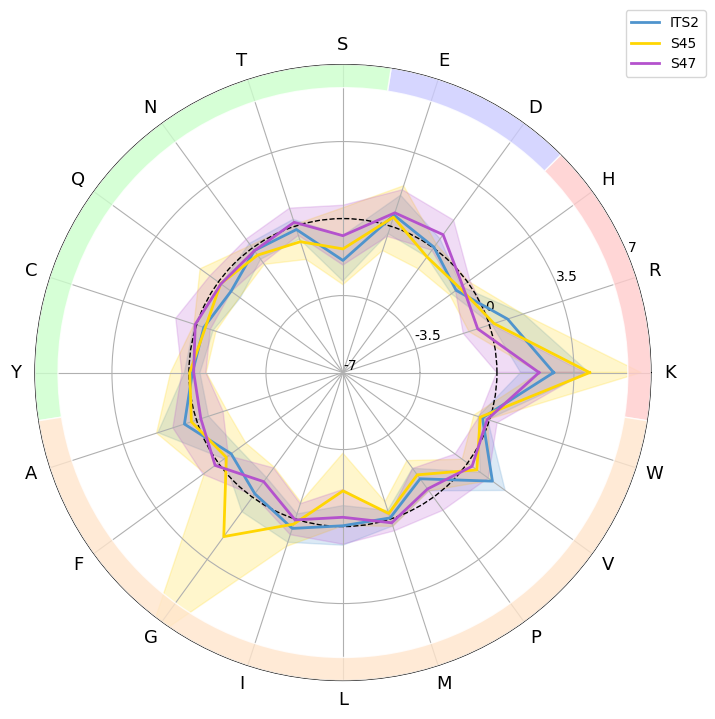

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

def bootstrap_diff_ci(data1, data2, n_bootstraps=10000, ci=95):

    diffs = []
    for _ in range(n_bootstraps):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        diffs.append(np.mean(sample1) - np.mean(sample2))
    lower = np.percentile(diffs, (100 - ci) / 2)
    upper = np.percentile(diffs, 100 - (100 - ci) / 2)
    return lower, upper

def plot_radar_plot_difference(df, n_bootstraps=1000, ci_level=95):

    df = df.copy()

    palette = {
        'S45': '#FFD602',
        'S47': '#B452CD',
        'ITS2': '#4F94CD',
        'All Nuclear Proteins': '#757575'
    }
    baseline_label = 'All Nuclear Proteins'
    
    groups_order = [
        ('Positive', list("KRH")),
        ('Negative', list("DE")),
        ('Polar',    list("STNQCY")),
        ('Not-polar', list("AFGILMPVW"))
    ]
    
    new_aa_list = []
    for group_name, aas in groups_order:
        new_aa_list.extend(aas)
    if len(new_aa_list) != 20:
        raise ValueError("Total number of amino acids is not 20. Check your groups_order definition.")
    
    for aa in new_aa_list:
        df[f"{aa}_percent"] = df['Sequence'].str.count(aa) / df['Sequence'].str.len() * 100
    percent_cols = [f"{aa}_percent" for aa in new_aa_list]
    
    groups = df.groupby('Label')
    group_stats = {}
    for label, group in groups:
        means = {}
        for col in percent_cols:
            means[col] = group[col].mean()
        group_stats[label] = means

    if baseline_label not in group_stats:
        raise ValueError(f"Baseline label '{baseline_label}' not found in data.")
    baseline_means = group_stats[baseline_label]
    diff_stats = {}
    for label, means in group_stats.items():
        diff_stats[label] = {}
        for aa in new_aa_list:
            col = f"{aa}_percent"
            diff_stats[label][col] = means[col] - baseline_means[col]

    ci_stats = {}
    for label in df['Label'].unique():
        if label == baseline_label:
            continue
        ci_stats[label] = {}
        group_data = df[df['Label'] == label]
        baseline_data = df[df['Label'] == baseline_label]
        for aa in new_aa_list:
            col = f"{aa}_percent"
            data1 = group_data[col].values
            data2 = baseline_data[col].values
            ci_stats[label][col] = bootstrap_diff_ci(data1, data2, n_bootstraps=n_bootstraps, ci=ci_level)
    
    N = len(new_aa_list)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], new_aa_list, fontsize=13)
    
    diff_values_all = []
    for label, diffs in diff_stats.items():
        if label == baseline_label:
            continue
        for aa in new_aa_list:
            diff_values_all.append(diffs[f"{aa}_percent"])
    if diff_values_all:
        diff_limit = max(abs(np.min(diff_values_all)), abs(np.max(diff_values_all))) * 1.5
        diff_limit = math.ceil(diff_limit)
    else:
        diff_limit = 1
    outer_ring_bottom = diff_limit * 0.85
    outer_ring_height = diff_limit * 0.15
    new_max = outer_ring_bottom + outer_ring_height
    plt.ylim(-diff_limit, new_max)
    
    for label, diffs in diff_stats.items():
        if label == baseline_label:
            continue
        diff_values = [diffs[f"{aa}_percent"] for aa in new_aa_list]
        diff_values += diff_values[:1]
        color = palette.get(label, '#333333')
        ax.plot(angles, diff_values, linewidth=2, linestyle='solid', label=label, color=color)
        
        ci_lower = [ci_stats[label][f"{aa}_percent"][0] for aa in new_aa_list]
        ci_upper = [ci_stats[label][f"{aa}_percent"][1] for aa in new_aa_list]

        ci_lower.append(ci_lower[0])
        ci_upper.append(ci_upper[0])
        
        theta_polygon = np.concatenate([angles, angles[::-1]])
        r_polygon = np.concatenate([ci_lower, ci_upper[::-1]])
        ax.fill(theta_polygon, r_polygon, color=color, alpha=0.2)
    
    rticks = np.linspace(-new_max, new_max, 5)
    rtick_labels = [f'{tick:.1f}'.rstrip('0').rstrip('.') for tick in rticks]
    ax.set_rticks(rticks)
    ax.set_yticklabels(rtick_labels)
    
    gridlines = ax.yaxis.get_gridlines()
    for tick, grid in zip(rticks, gridlines):
        if np.isclose(tick, 0):
            grid.set_linewidth(1)
            grid.set_linestyle('--')
            grid.set_color('black')
    
    group_colors = {
        'Positive': '#FFCCCC',
        'Negative': '#CCCCFF',
        'Polar':    '#CCFFCC',
        'Not-polar': '#FFE5CC'
    }
    total_aas = len(new_aa_list)
    cum_index = 0
    for group_name, aas in groups_order:
        group_len = len(aas)
        left_angle = ((cum_index - 0.5) / total_aas) * 2 * np.pi
        if left_angle < 0:
            left_angle += 2 * np.pi
        width = (group_len / total_aas) * 2 * np.pi
        ax.bar(left_angle, outer_ring_height, width=width, bottom=outer_ring_bottom,
               color=group_colors.get(group_name, '#999999'),
               edgecolor='white', alpha=0.8, zorder=10, align='edge')
        cum_index += group_len

    # plt.title('Radar Plot of Difference in Mean Amino Acid Percentages\n(Relative to "all nuclear proteins")', 
    #           size=15, y=1.08)
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.savefig('results/revision_plots/microscopy_radar_plot_difference.svg', bbox_inches='tight')
    plt.show()

plot_radar_plot_difference(data_all_prots)

**Violin plot of pI, mass, and disorder**

S47 vs S45: p = 0.097
S47 vs ITS2: p = 0.058
S47 vs All Nuclear Proteins: p = 0.207
S45 vs ITS2: p = 0.790
S45 vs All Nuclear Proteins: p = 0.229
ITS2 vs All Nuclear Proteins: p = 0.118


/tmp/ipykernel_2484144/2859526603.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2484144/2859526603.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


Y-axis limits: 2.90 to 9.89


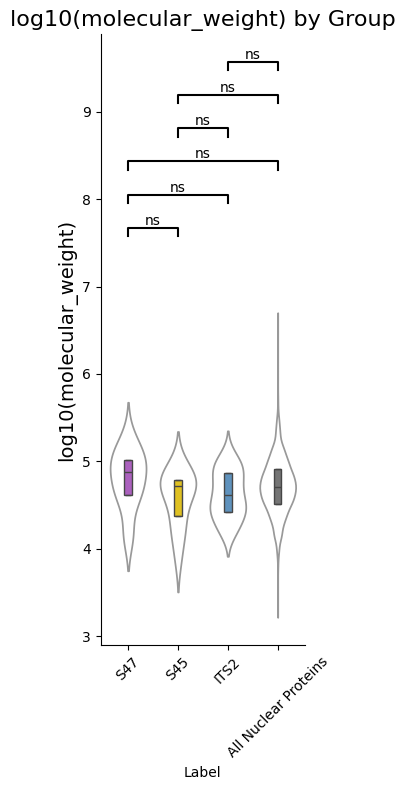

S47 vs S45: p = 0.006
S47 vs ITS2: p = 0.181
S47 vs All Nuclear Proteins: p = 0.843
S45 vs ITS2: p = 0.165
S45 vs All Nuclear Proteins: p = 0.000
ITS2 vs All Nuclear Proteins: p = 0.012
Y-axis limits: 1.57 to 18.18


/tmp/ipykernel_2484144/2859526603.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2484144/2859526603.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


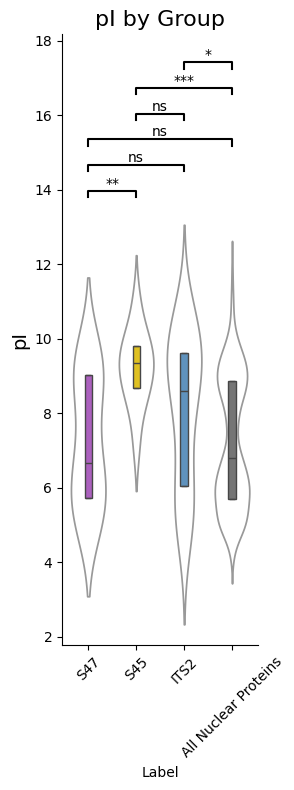

S47 vs S45: p = 0.486
S47 vs ITS2: p = 0.847
S47 vs All Nuclear Proteins: p = 0.946
S45 vs ITS2: p = 0.193
S45 vs All Nuclear Proteins: p = 0.171
ITS2 vs All Nuclear Proteins: p = 0.749
Y-axis limits: -0.41 to 1.54


/tmp/ipykernel_2484144/2859526603.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2484144/2859526603.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


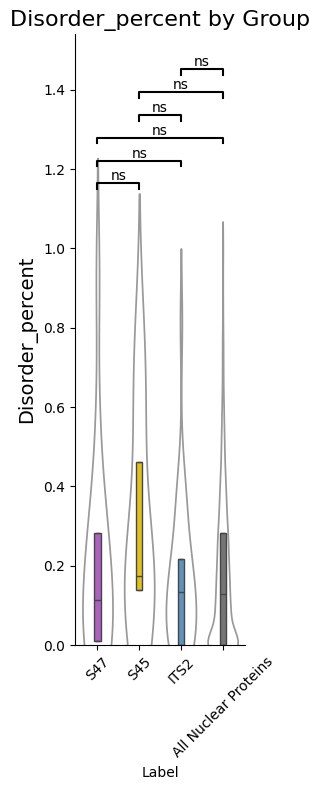

In [12]:
def plot_grouped_violin(df, group_col='group', value_col='value', log=False, test=None, order=None):
    assert test in ["ttest", "mannwhitneyu"], "test must be either 'ttest' or 'mannwhitneyu'"
    plot_df = df.copy()

    if log:
        plot_df[f"log10({value_col})"] = np.log10(plot_df[value_col] + 1)
        value_col = f"log10({value_col})"

    if order is None:
        order = list(plot_df[group_col].unique())

    comparisons = list(itertools.combinations(order, 2))
    results = []
    for group_a, group_b in comparisons:
        data_a = plot_df[plot_df[group_col] == group_a][value_col].dropna()
        data_b = plot_df[plot_df[group_col] == group_b][value_col].dropna()
        if test == "ttest":
            stat, p_val = ttest_ind(data_a, data_b, equal_var=False)
        elif test == "mannwhitneyu":
            stat, p_val = mannwhitneyu(data_a, data_b, alternative='two-sided')


        print(f'{group_a} vs {group_b}: p = {p_val:.3f}')
        results.append((group_a, group_b, p_val))

    hex_palette =   {
        'S45': '#FFD602',
        'S47': '#B452CD',
        'ITS2': '#4F94CD',
        'All Nuclear Proteins': '#757575'
        }
    
    white_palette = {key: '#FFFFFF' for key in hex_palette}

    plt.figure(figsize=(3, 8))

    sns.violinplot(
        x=group_col, y=value_col, data=plot_df, order=order,
        palette=white_palette, inner=None, gap=0.1, zorder=0
    )
    ax = sns.boxplot(
        x=group_col, y=value_col, data=plot_df, order=order,
        palette=hex_palette, showfliers=False,
        width=0.15, whis=0, zorder=2
    )

    y_max = plot_df[value_col].max() * 1.15
    y_step = y_max / 20

    tick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
    tick_map = {label: pos for label, pos in zip(tick_labels, ax.get_xticks())}

    for idx, (group_a, group_b, p_val) in enumerate(results):
        x1, x2 = tick_map[group_a], tick_map[group_b]
        y, h = y_max + idx * y_step, y_step / 4
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='black')
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
        ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color='black')

    plt.title(f'{value_col} by Group', fontsize=16)
    plt.ylabel(value_col, fontsize=14)
    plt.xticks(rotation=45)

    sns.despine()
    plt.tight_layout()

    y_min, y_max = ax.get_ylim()
    print(f"Y-axis limits: {y_min:.2f} to {y_max:.2f}")
    if value_col == "pI":
        plt.ylim(1.77, 18.17)
    if value_col == "Length":
        plt.ylim(0.91, 6.87)
    if value_col == "molecular_weight":
        plt.ylim(2.99,7.87)
    if value_col == "Disorder_percent":
        plt.ylim(-0, 1.54)
    plt.savefig(f'results/revision_plots/microscopy_violin_{value_col}.svg')
    plt.show()

from Bio.SeqUtils.ProtParam import ProteinAnalysis

aa_map = {
    'U': 'C',  # Selenocysteine → Cysteine
    'O': 'K',  # Pyrrolysine → Lysine
    'B': 'N',  # Aspartic acid/Asparagine (Asx) → Asparagine
    'Z': 'Q',  # Glutamic acid/Glutamine (Glx) → Glutamine
    'J': 'L',  # Leu/Ile ambiguity → Leucine
    'X': ''    # Unknown amino acid → removed
}

def clean_sequence(seq):
    seq = seq.upper()
    for old, new in aa_map.items():
        seq = seq.replace(old, new)
    return seq

def get_mw(seq):
    seq = clean_sequence(seq)
    if len(seq) == 0:
        return 0 
    return ProteinAnalysis(seq).molecular_weight()
order = ["S47", "S45", "ITS2", "All Nuclear Proteins"]
data_all_prots["molecular_weight"] = data_all_prots["Sequence"].apply(get_mw)

data_all_prots["pI"] = data_all_prots["Sequence"].apply(lambda x: IsoelectricPoint.IsoelectricPoint(x).pi())

plot_grouped_violin(data_all_prots, group_col='Label', value_col='molecular_weight', log=True, test="mannwhitneyu", order=order)
plot_grouped_violin(data_all_prots, group_col='Label', value_col='pI', log=False, test="mannwhitneyu",order=order)
plot_grouped_violin(data_all_prots, group_col='Label', value_col='Disorder_percent', log=False, test="mannwhitneyu",order=order)
